# Image labeling

In this project, we will try to classify restaurant revews photos. To achieve this, we will use two differents methods :
1. The first approach will be to use the SIFT description method to compute descriptors on every images and use a K-means like algorithm to cluster the descriptors and hopefully match the descriptors clusters to the real labels.
2. The second will use tranfer learning. From a pre-trained CNN model (VGG16), we will connect to its end some new layers including a classifier one and train those new layers to recognize the photos labels.

## Image processing by SIFT description

For this part, my method will be inspired from [this webinar](https://app.livestorm.co/openclassrooms-1/pretraitement-dimages-detecter-automatiquement-la-meteo?type=detailed) (french).

### Importing correct images

First, because we will use tensorflow module, we need to make sure to filter the dataset on images that tf can handle (some specific format and not corrupted images).

In [2]:
from pathlib import Path
import imghdr


def is_image_usable_by_tf(image_path, extension):
    is_an_image = True
    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png", '.jpg'] # jpg is not accepted but we will rename them later to jpeg (because they are exactly the same but with different names)
    filepath = image_path + extension

    # Check if image type is accepted by TF
    if Path(filepath).suffix.lower() not in img_type_accepted_by_tf:
        print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
        is_an_image = False
    
    else:
        # Check if corrupted
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image (probably corrupted)")
            is_an_image = False 

    return is_an_image
    

In [3]:
import simplejson as json
import pandas as pd

directory_path = './Dataset/yelp_photos_comp/'
json_file_name = 'photos.json'
photos_path = 'photos/'

nb_images_to_import = 3000

lines_array = []

with open(f"{directory_path}{json_file_name}", encoding='utf-8') as f:

    for line in f:
        line = json.loads(line)
        # Insert json line in the dataFrame if the image is valid
        if is_image_usable_by_tf(f"{directory_path}{photos_path}{line['photo_id']}", '.jpg'):
            lines_array.append(line)  
    
        if len(lines_array) >= nb_images_to_import:
            break

photos_df = pd.DataFrame(lines_array)
photos_df.head()

./Dataset/yelp_photos_comp/photos/ydm3g1wUWSxJnMPgHk2JhQ.jpg is not an image (probably corrupted)


,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


### Image processing

Each image will be pre-processed before we apply the SIFT description method on it. The pre-processing consists in some image filtering (grayscale, equalization and noise reduction).

In [3]:
from PIL import Image, ImageOps, ImageFilter

def image_preprocessing(path):
    img = Image.open(path)
    
    # Set to grayscale
    new_img = ImageOps.grayscale(img)

    # Equalize histogram
    new_img = ImageOps.equalize(new_img)

    # Reducing the noise
    new_img = new_img.filter(ImageFilter.MinFilter)

    return new_img

In [4]:
import cv2 as cv
import numpy as np

def find_descriptors(img):
    # Convert PIL image to OpenCV image
    open_cv_image = cv.cvtColor(np.array(img), cv.COLOR_RGB2BGR)
    image_described = open_cv_image.copy()

    # Keypoints are the location of the descriptors and descriptors is their content
    sift = cv.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(open_cv_image,None)

    image_described = cv.drawKeypoints(image_described, keypoints, open_cv_image)

    return [image_described, keypoints, descriptors]

Processing image 0
    Preprocessing time: 0.02s
    Description time: 0.035s


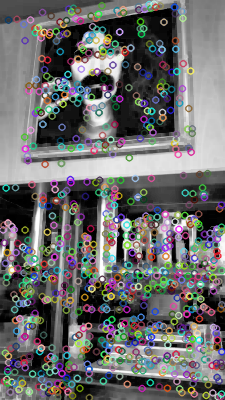

    descriptors :
[[  0.   0.   0. ...   1.   1.   4.]
 [  0.   0.   0. ...   9.  29. 105.]
 [ 34.  22.   0. ...  46.   1.   6.]
 ...
 [  4.  13.  73. ...   4.   6.   3.]
 [ 61.  27.   2. ...   0.   0.   9.]
 [  0.   1.   1. ...   8.   0.   0.]]
    keypoints :
(< cv2.KeyPoint 0000020CF7613D50>, < cv2.KeyPoint 0000020CF7613DB0>, < cv2.KeyPoint 0000020CF7613DE0>, < cv2.KeyPoint 0000020CF7613E10>, < cv2.KeyPoint 0000020CF7613E40>, < cv2.KeyPoint 0000020CF7613E70>, < cv2.KeyPoint 0000020CF7613EA0>, < cv2.KeyPoint 0000020CF7613ED0>, < cv2.KeyPoint 0000020CF7613F00>, < cv2.KeyPoint 0000020CF7613F30>)

-----------------------------------------------------
Processing image 1
    Preprocessing time: 0.022s
    Description time: 0.0601s

-----------------------------------------------------
Processing image 2
    Preprocessing time: 0.017s
    Description time: 0.05s

-----------------------------------------------------
Processing image 3
    Preprocessing time: 0.017s
    Description time: 0.

In [5]:
import time

nb_images_to_process = 1000

descriptors_array = []

for i in range(nb_images_to_process):
    print('Processing image {}'.format(i))

    # Open Image
    photo_path = './Dataset/yelp_photos_comp/photos/' + str(photos_df.loc[i, 'photo_id']) + '.jpg'
    
    start_time = time.time()
    # Preprocessing image
    img = image_preprocessing(photo_path)
    preprocessing_time = time.time()
    print('    Preprocessing time: ' + str(round(preprocessing_time - start_time,4)) + 's')

    # Find descriptors
    img, keypoints, descriptors = find_descriptors(img)
    description_time = time.time()
    print('    Description time: ' + str(round(description_time - preprocessing_time,4)) + 's')

    descriptors_array.append(descriptors)

    if i == 0:
        display(Image.fromarray(img))
        print(f'    descriptors :\n{descriptors[:10]}')
        print(f'    keypoints :\n{keypoints[:10]}')
    print('\n-----------------------------------------------------')

flatten_descriptors = [descriptor for image_descriptors in descriptors_array for descriptor in image_descriptors]
descriptors_image_list = [len(descriptors) for descriptors in descriptors_array]
print(f"Descriptors_array :\n({len(flatten_descriptors)}, {len(flatten_descriptors[0])})")

### Descriptors computation

Now that we have every descriptors of every images, we can cluster them. We usually chose the number of clusters by the root of the number of descriptors.

In [6]:
from sklearn.cluster import MiniBatchKMeans
import math

nb_descripters = len(flatten_descriptors)

nb_clusters = round(math.sqrt(nb_descripters))


print(f"There are {nb_descripters} descriptors so we chose square root of clusters number : ~{nb_clusters}")

start_time = time.time()
mnKmeans = MiniBatchKMeans(n_clusters=nb_clusters, random_state=0)
mnKmeans.fit(flatten_descriptors)
clustering_time = time.time()
print('Clustering time: ' + str(round(clustering_time - start_time,4)) + 's')

There are 1308018 descriptors so we chose square root of clusters number : ~1144
Clustering time: 36.1426s


When having every clusters for each images, we do a counter.

Eg: 
```
Image 1
cluster 0 : 200 descriptors
cluster 1 : 173 descriptors
...
cluster 1143 : 1 descriptor
cluster 1144 : 0 descriptors

```

In [7]:
import collections

flat_desc = flatten_descriptors

# For each image, here is the repartition
images_counter = []

for image_nb in range(nb_images_to_process):
    nb_descriptors = descriptors_image_list[image_nb]
    image_descriptors = flat_desc[:nb_descriptors]
    descriptors_prediction = mnKmeans.predict(image_descriptors)

    # remove the decriptors from the list
    flat_desc = flat_desc[nb_descriptors:]
        
    # Count how many descriptors are in each cluster
    descriptors_counter = collections.Counter(descriptors_prediction)

    cluster_counter = [0] * nb_clusters

    for key, value in sorted(descriptors_counter.items()):
        cluster_counter[key] = value

    images_counter.append(cluster_counter)

We can see that as if each image is represented in a space of 1144 dimensions. Then we will reduce this space to a 2D space in order to represent the images.
We first start by doing a PCA and then a TSNE.

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


pca = PCA(n_components=0.99, svd_solver='full')
images_counter_PCA = pca.fit_transform(images_counter)
print(f"explained variance by PCA : {round(pca.explained_variance_ratio_.sum()*100, 2)}%")

# T-SNE
tsne = TSNE(n_components=2, perplexity=40, n_iter=2000)
images_counter_PCA_TSNE = tsne.fit_transform(images_counter_PCA)

explained variance by PCA : 99.01%


c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 6\natural-language-processing-and-image-recognition\new_env\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\augustin\Desktop\Projets\Formations\Openclassrooms\Projet 6\natural-language-processing-and-image-recognition\new_env\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


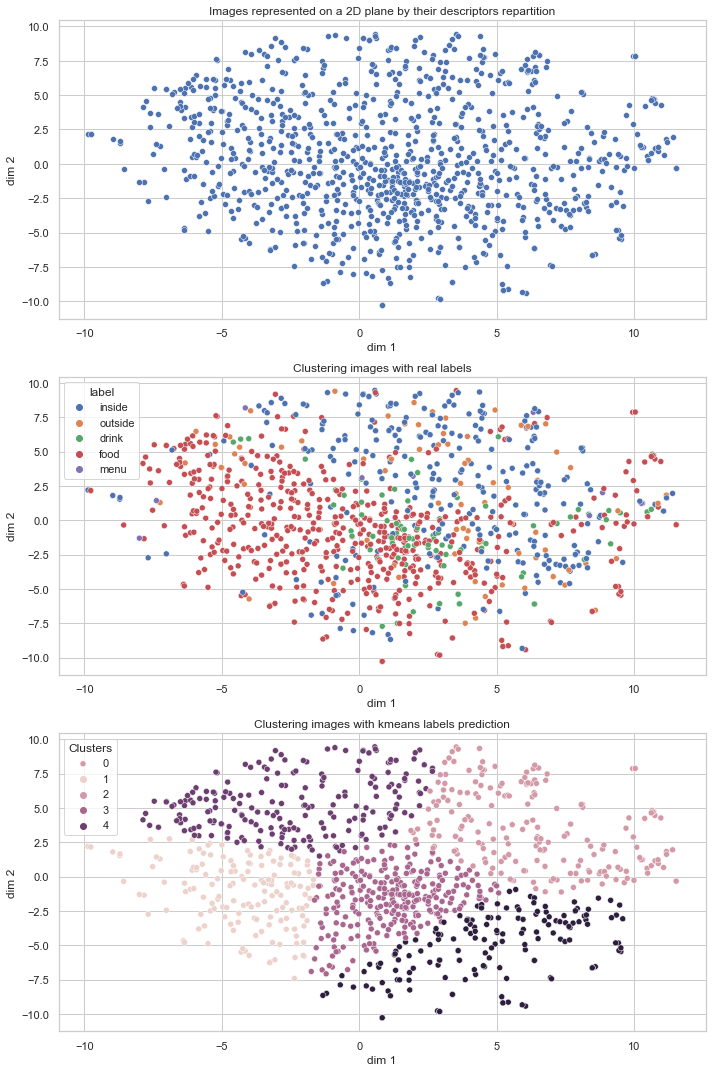

In [9]:

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
sns.set(style='whitegrid')

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

sns.scatterplot(data = pd.DataFrame(images_counter_PCA_TSNE, columns=['x', 'y']), x='x', y='y', ax=axs[0])
axs[0].title.set_text('Images represented on a 2D plane by their descriptors repartition')
axs[0].set_xlabel('dim 1')
axs[0].set_ylabel('dim 2')

sns.scatterplot(data = pd.DataFrame(images_counter_PCA_TSNE, columns=['x', 'y']), x='x', y='y', hue=photos_df.loc[:, 'label'], ax=axs[1])
axs[1].title.set_text('Clustering images with real labels')
axs[1].set_xlabel('dim 1')
axs[1].set_ylabel('dim 2')



# Clustering
possible_labels = set(photos_df.loc[:, 'label'])
kmeans = MiniBatchKMeans(n_clusters=len(possible_labels), random_state=0)
image_labels_predict = kmeans.fit_predict(images_counter_PCA_TSNE)

sns.scatterplot(data = pd.DataFrame(images_counter_PCA_TSNE, columns=['x', 'y']), x='x', y='y', hue=image_labels_predict, ax=axs[2])
axs[2].title.set_text('Clustering images with kmeans labels prediction')
#set labels name
axs[2].set_xlabel('dim 1')
axs[2].set_ylabel('dim 2')
axs[2].legend([f"{i}" for i in range(len(possible_labels))], title='Clusters', loc='upper left')


# Set backgrounds to white
plt.gcf().set_facecolor('white')
plt.tight_layout()

### Clusters analysis

We will try to match the clusters found by the Kmeans with the classes of the dataset.

In [10]:
collections.Counter(image_labels_predict)

for cluster, number in collections.Counter(image_labels_predict).items():
    print(f"Cluster {cluster} : {number} images")

Cluster 1 : 203 images
Cluster 4 : 160 images
Cluster 3 : 208 images
Cluster 2 : 276 images
Cluster 0 : 153 images


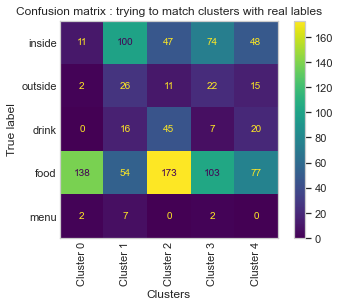

In [11]:
from sklearn import metrics

labels_to_cluster = photos_df.loc[:nb_images_to_process -1, 'label'].replace(to_replace=['inside', 'outside', 'drink', 'food', 'menu'], value=[0, 1, 2, 3, 4])

conf_mat = metrics.confusion_matrix(labels_to_cluster, image_labels_predict)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['inside', 'outside', 'drink', 'food', 'menu'])
disp.plot()
# Set backgrounds to white
plt.gcf().set_facecolor('white')
# Thick labels
plt.tick_params(axis=u'both', which=u'both',length=0)
# Remove the grid
plt.grid(visible=None)


# change the axis labels
ax = plt.gca()
ax.set_title('Confusion matrix : trying to match clusters with real lables')
ax.set_xlabel('Clusters')
ax.set_xticklabels([f"Cluster {i}" for i in range(len(possible_labels))], rotation=90)
plt.show()

Because we did a Kmeans the predicted labels doesn't correspond to the classes of the dataset. We need to make them match.

When trying to match the labels and clusters, we usually use the argmax function : the cluster containing the most in our class is the one describing the class.

However, here is impossible because the clustering isn't representative at all of the classes. To demonstrate this, let's start the process :
1. What cluster does represent the class "inside" ? It seems that it is the cluster 0, with 88 images classified correctly. So "inside" = cluster 0.
2. What cluster does represent the class "outside" ? It is still the same cluster 0.

We can see that this clustering is so bad that we can't match the classes. In fact, by looking at the real label distribution, it was very clear that no clustering methods could achieve a good result. Next time, clustering before doing the dimension reduction may result in better results.

### Conclusion

The SIFT descriptors doesn't seems very relevant for this task. We can make the assumption that menu, drinks and photos of the restaurant are very difficult to differentiate.
We sould try another approach and maybe try using transfer learning on a pre-trained CNN.

## Image processing by using transfer learning on VGG16

We will use the VGG16 model and replace the last layer with our classifier to learn to predict the classes of the dataset.

### Organising the dataset

Because of how keras dataset are imported, we need some folders manipulation to sort our dataset.

In [4]:
import tensorflow
import keras

import shutil

possible_labels = set(photos_df.loc[:, 'label'])

# Creating folders and subfolders

try:
    # clean the photos_ds directory
    shutil.rmtree('./Dataset/yelp_photos_comp/photos_train_ds/')
except:
    pass
# create the photos_ds directory
os.mkdir('./Dataset/yelp_photos_comp/photos_train_ds/')

for label in possible_labels:
    try:
        shutil.rmtree(f'./Dataset/yelp_photos_comp/photos_train_ds/{label}/')
    except:
        pass
    
    os.mkdir(f'./Dataset/yelp_photos_comp/photos_train_ds/{label}/')

In [5]:
# Must be <= to nb_images_to_import
nb_photos_to_train_on = 3000
df_to_train_on = photos_df.sample(nb_photos_to_train_on)

for photo_id in df_to_train_on.loc[:, 'photo_id']:
    photo_path = f'./Dataset/yelp_photos_comp/photos/{str(photo_id)}.jpg'
    label = df_to_train_on.loc[df_to_train_on.loc[:, 'photo_id'] == photo_id, 'label'].values[0]
    destination_path = f'./Dataset/yelp_photos_comp/photos_train_ds/{label}/{str(photo_id)}.jpeg'
    shutil.copy(photo_path, destination_path)

In [6]:
from keras.utils import image_dataset_from_directory
import os


# Load the dataset
train_ds = image_dataset_from_directory(directory = './Dataset/yelp_photos_comp/photos_train_ds/',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (224, 224),
    seed = 42,
    validation_split = 0.2,
    subset = 'training')

validation_ds = image_dataset_from_directory(directory = './Dataset/yelp_photos_comp/photos_train_ds/',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (224, 224),
    seed = 42,
    validation_split = 0.2,
    subset = 'validation')

Found 3000 files belonging to 5 classes.
Using 2400 files for training.
Found 3000 files belonging to 5 classes.
Using 600 files for validation.


### Creating our new model

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten


# Import the model without the last Dense layer (usually used for classification between the hundreds of classes)
model = VGG16(include_top = False, input_shape = (224, 224, 3))

# flag loaded layers as not trainable (we only want to train our new layers)
for layer in model.layers:
	layer.trainable = False

# add new classifier layers (trainable by default)
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(5, activation='softmax')(class1)

# define new model
model = Model(inputs=model.inputs, outputs=output)

# summarize
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Fitting

Because our model can take a long time to fit, we can chose to use existing weights.

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
import time

nb_epochs = ''
condition = True
while condition:
    nb_epochs = input("How many epochs do you want to train ? ")
    if nb_epochs.isdigit():
        if int(nb_epochs) >= 0:
            nb_epochs = int(nb_epochs)
            condition = False

import_weights = None
while import_weights != 'y' and import_weights != 'n':
    import_weights = input("Do you want to import weights from a previous model ? (y/n) ")

    if import_weights == 'y':
        # check path
        path_to_weights = input("Enter ckpt file path")
        while not os.path.isdir(os.path.dirname(path_to_weights)):
            path_to_weights = input("Enter ckpt file path")



model.compile(optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc'])


if import_weights == 'y':
    model.load_weights(path_to_weights)

if nb_epochs > 0:
    checkpoint_path = "training_weights/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, save_freq='epoch')


    print('Fitting model...')
    start = time.time()
    history = model.fit(train_ds, epochs=nb_epochs, validation_data=validation_ds, callbacks=[cp_callback])
    end = time.time()
    print(f'Fitting model took {end - start} seconds')

    model.save_weights('./training_weights/weights.h5')


### Displaying the training results

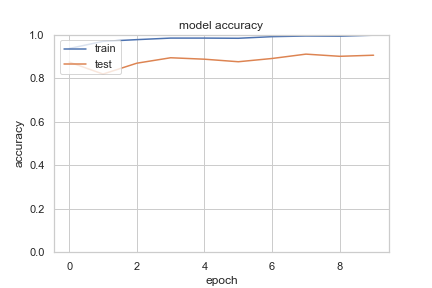

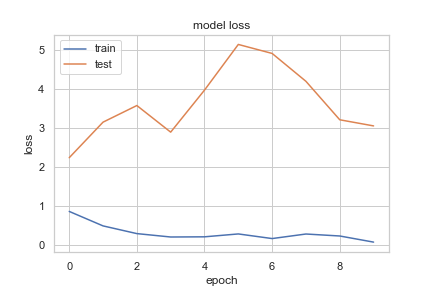

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

if nb_epochs > 0:

    # printing Accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.ylim(0, 1)

    # print figures on white
    plt.gcf().set_facecolor('white')
    plt.savefig('model accuracy.png')
    plt.show()


    # printing Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # print figures on white
    plt.gcf().set_facecolor('white')
    plt.savefig('model loss.png')
    plt.show()

    # Evaluation on test set
    scal_test_loss = model.evaluate(validation_ds)
    print(f'Test loss: {scal_test_loss[0]}')

else:
    display(Image.open('model_accuracy.png'))
    display(Image.open('model_loss.png'))

### Examples of the predictions

1/1 [==============================] - 3s 3s/step
Adjusted Rand Score: 0.8427137317435581


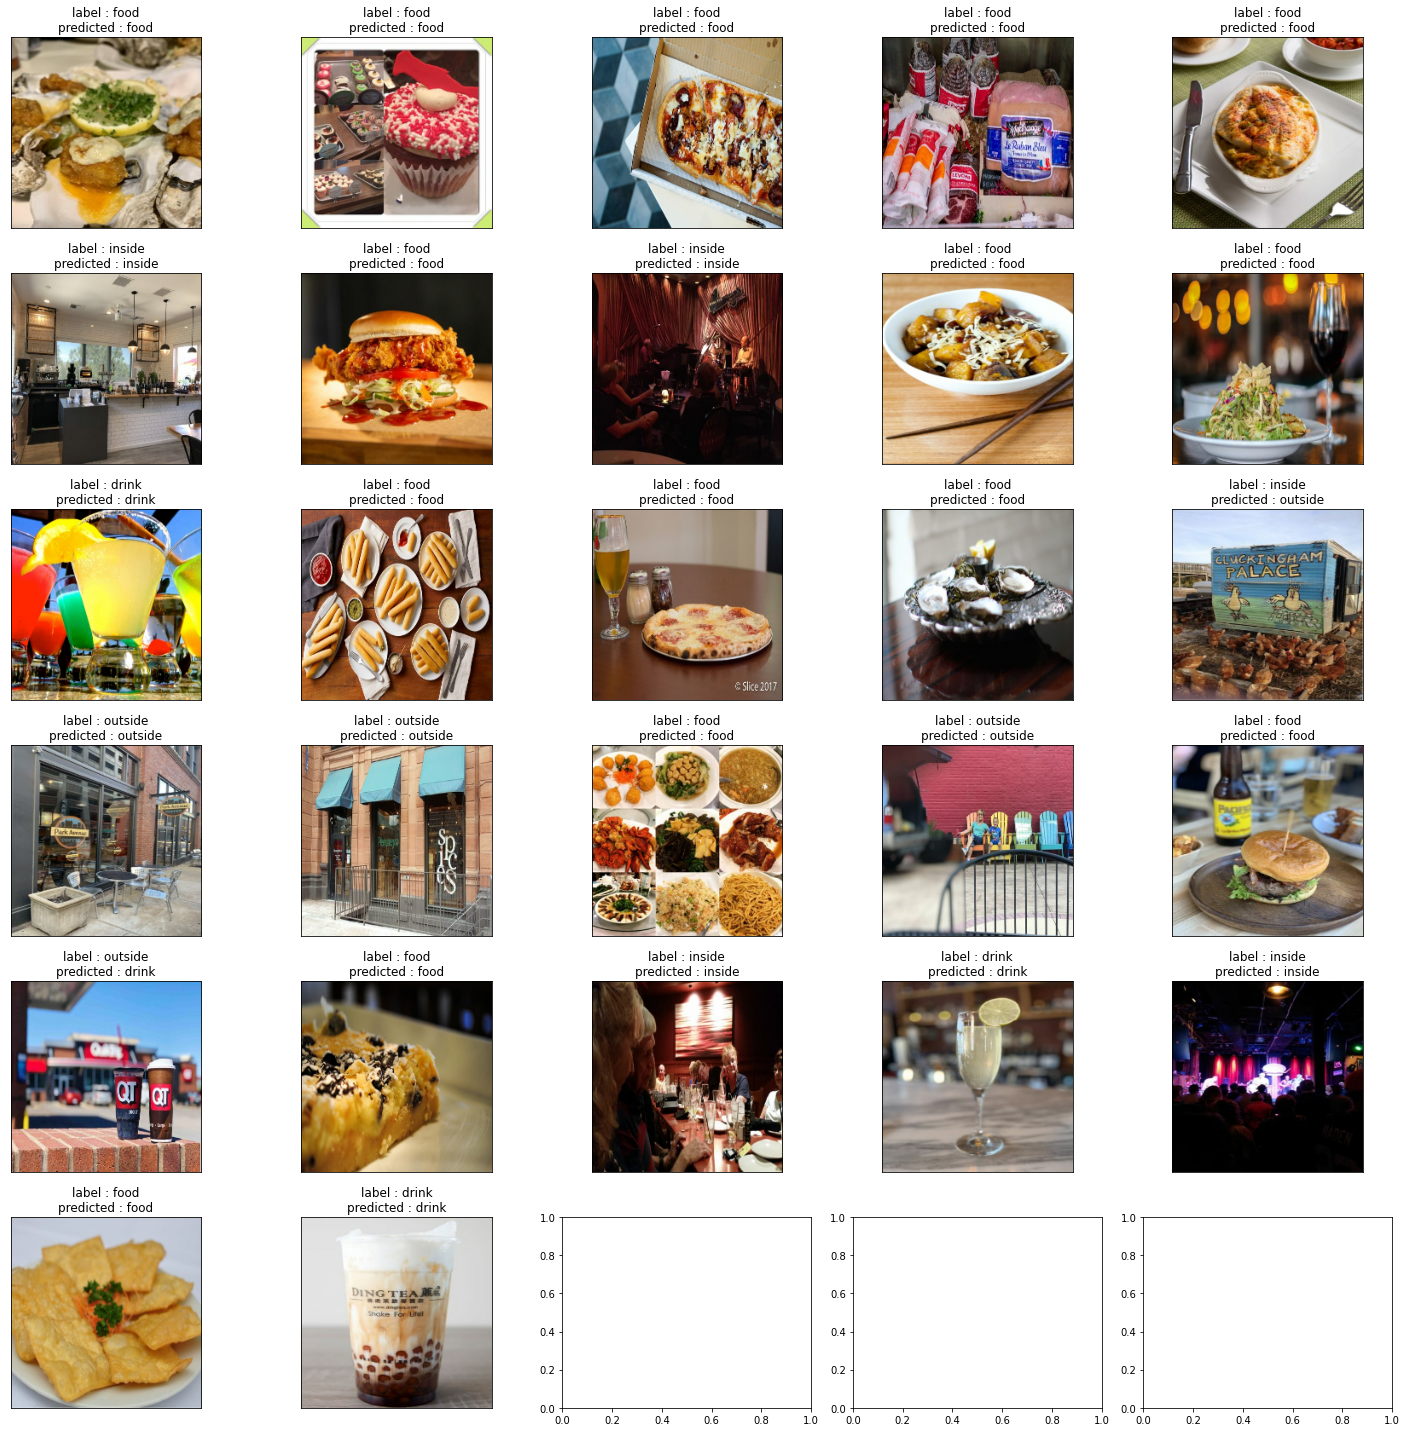

In [16]:
import numpy as np

from sklearn.metrics import adjusted_rand_score

possible_labels = list(possible_labels)
possible_labels.sort()

for images, labels in validation_ds.take(1):

    predictions_images = model.predict(images)

    predictions_class = [np.argmax(prediction) for prediction in predictions_images]
    labels_class = [np.argmax(label) for label in labels]
    
    fig, axs = plt.subplots(6, 5, figsize=(20, 20))
    for i in range(32):
        predicted_class = predictions_class[i]
        predicted_class_label = possible_labels[predicted_class]

        real_class = labels_class[i]
        real_class_label = possible_labels[real_class]

        ax = axs[i//6, i%5]
        # print(f"{i} : [{i//5}][{i%5}]")
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(f"label : {real_class_label}\npredicted : {predicted_class_label}")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.gcf().set_facecolor('white')
plt.tight_layout()

print(f'Adjusted Rand Score: {adjusted_rand_score(labels_class, predictions_class)}')

## Conclusion

Because in our situation, False positive rate are as important as false negative rate (unlike in cancer detection for example), we can use a neutral metric system.
We use [ARI ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) because it is fast to compute and great for classification.
Because of the clusters non-similarity, in the SIFT detection, we couldn't even try to compute ARI but in transfer learning we got about which is a really good score.

Even if SIFT descriptors is a proven method, we can see that using transfer learning is a fast and easy method to get a great classifier. In the future, we could also try to fine-tune it by training the pre-existing layers (but with a much lower learning rate).